<a href="https://colab.research.google.com/github/kzawora/KerasHTR/blob/main/KerasHTR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!nvidia-smi

Wed Dec 30 21:41:32 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!mkdir -p /content/dataset/words
!cp /content/drive/MyDrive/deeplearning/words.tgz /content/dataset/words.tgz

In [4]:
!cp /content/drive/MyDrive/deeplearning/words_train_clean.txt /content/dataset/words_train.txt
!cp /content/drive/MyDrive/deeplearning/words_val.txt /content/dataset/words_val.txt
!cp /content/drive/MyDrive/deeplearning/words_test.txt /content/dataset/words_test.txt


In [5]:
!tar zxfv /content/dataset/words.tgz -C /content/dataset/words

Streaming output truncated to the last 5000 lines.
r06/r06-137/r06-137-05-08.png
r06/r06-137/r06-137-05-09.png
r06/r06-137/r06-137-05-10.png
r06/r06-137/r06-137-05-11.png
r06/r06-137/r06-137-06-00.png
r06/r06-137/r06-137-06-01.png
r06/r06-137/r06-137-06-02.png
r06/r06-137/r06-137-06-03.png
r06/r06-137/r06-137-06-04.png
r06/r06-137/r06-137-06-05.png
r06/r06-137/r06-137-06-06.png
r06/r06-137/r06-137-06-07.png
r06/r06-137/r06-137-06-08.png
r06/r06-137/r06-137-07-00.png
r06/r06-137/r06-137-07-01.png
r06/r06-137/r06-137-07-02.png
r06/r06-137/r06-137-07-03.png
r06/r06-137/r06-137-07-04.png
r06/r06-137/r06-137-07-05.png
r06/r06-137/r06-137-07-06.png
r06/r06-137/r06-137-07-07.png
r06/r06-137/r06-137-07-08.png
r06/r06-137/r06-137-07-09.png
r06/r06-137/r06-137-07-10.png
r06/r06-137/r06-137-07-11.png
r06/r06-137/r06-137-07-12.png
r06/r06-137/r06-137-08-00.png
r06/r06-137/r06-137-08-01.png
r06/r06-137/r06-137-08-02.png
r06/r06-137/r06-137-08-03.png
r06/r06-137/r06-137-08-04.png
r06/r06-137/r06-137

# Training environment config

In [6]:
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Reshape, Dense, LSTM, add, concatenate, Dropout, Lambda, Flatten
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras import backend
import itertools
from google.colab.patches import cv2_imshow
import math
import editdistance

In [7]:
class Config():
    width = 128
    height = 32
    nb_channels = 1
    batch_size = 128
    max_label_len = 32
    conv_filter_size = [64, 128, 256, 256, 512, 512, 512]
    lstm_nb_units=[128,128]
    timesteps=32
    dropout_rate=0.25
    lr=0.01
    characters =' !"#&\'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'
cfg = Config()

In [8]:
def ctc_lambda_func(args):
    iy_pred, ilabels, iinput_length, ilabel_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
#    iy_pred = iy_pred[:, 2:, :]  # no such influence
    return K.ctc_batch_cost(ilabels, iy_pred, iinput_length, ilabel_length)#, ctc_merge_repeated=True)
#    return tf.nn.ctc_loss(ilabels, iy_pred, ilabel_length, iinput_length)
    #tf.compat.v1.nn.ctc_loss(labels=ilabels, inputs=iy_pred, sequence_length=32, ctc_merge_repeated=True)

# Model

In [9]:

def CRNN(cfg):
    inputs = Input((cfg.width, cfg.height, cfg.nb_channels))
    c_1 = Conv2D(cfg.conv_filter_size[0], (3, 3), activation='relu', padding='same', name='conv_1')(inputs)
    c_2 = Conv2D(cfg.conv_filter_size[1], (3, 3), activation='relu', padding='same', name='conv_2')(c_1)
    c_3 = Conv2D(cfg.conv_filter_size[2], (3, 3), activation='relu', padding='same', name='conv_3')(c_2)
    bn_3 = BatchNormalization(name='bn_3')(c_3)
    p_3 = MaxPooling2D(pool_size=(2, 2), name='maxpool_3')(bn_3)

    c_4 = Conv2D(cfg.conv_filter_size[3], (3, 3), activation='relu', padding='same', name='conv_4')(p_3)
    c_5 = Conv2D(cfg.conv_filter_size[4], (3, 3), activation='relu', padding='same', name='conv_5')(c_4)
    bn_5 = BatchNormalization(name='bn_5')(c_5)
    p_5 = MaxPooling2D(pool_size=(2, 2), name='maxpool_5')(bn_5)

    c_6 = Conv2D(cfg.conv_filter_size[5], (3, 3), activation='relu', padding='same', name='conv_6')(p_5)
    c_7 = Conv2D(cfg.conv_filter_size[6], (3, 3), activation='relu', padding='same', name='conv_7')(c_6)
    bn_7 = BatchNormalization(name='bn_7')(c_7)

    bn_7_shape = bn_7.get_shape()
    reshape = Reshape(target_shape=(int(bn_7_shape[1]), int(bn_7_shape[2] * bn_7_shape[3])), name='reshape')(bn_7)

    fc_9 = Dense(cfg.lstm_nb_units[0], activation='relu', name='fc_9')(reshape)

    lstm_10 = LSTM(cfg.lstm_nb_units[0], kernel_initializer="he_normal", return_sequences=True, name='lstm_10')(fc_9)
    lstm_10_back = LSTM(cfg.lstm_nb_units[0], kernel_initializer="he_normal", go_backwards=True, return_sequences=True, name='lstm_10_back')(fc_9)
    lstm_10_add = add([lstm_10, lstm_10_back])

    lstm_11 = LSTM(cfg.lstm_nb_units[1], kernel_initializer="he_normal", return_sequences=True, name='lstm_11')(lstm_10_add)
    lstm_11_back = LSTM(cfg.lstm_nb_units[1], kernel_initializer="he_normal", go_backwards=True, return_sequences=True, name='lstm_11_back')(lstm_10_add)
    lstm_11_concat = concatenate([lstm_11, lstm_11_back])
    do_11 = Dropout(cfg.dropout_rate, name='dropout')(lstm_11_concat)

    fc_12 = Dense(len(cfg.characters)+1, kernel_initializer='he_normal', activation='softmax', name='fc_12')(do_11)

    prediction_model = Model(inputs=inputs, outputs=fc_12)

    labels = Input(name='labels', shape=[None], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')

    ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([fc_12, labels, input_length, label_length])

    training_model = Model(inputs=[inputs, labels, input_length, label_length], outputs=[ctc_loss])

    return training_model, prediction_model


In [10]:
def CRNN2(cfg):
    inputs = Input((cfg.width, cfg.height, cfg.nb_channels))
    kernelVals = [5, 5, 3, 3, 3]
    featureVals = [32, 64, 128, 128, 256]
    poolVals = [(2, 2), (2, 2), (1, 2), (1, 2), (1, 2)]
    numHidden = 256
    strideVals = poolVals
    conv_1 = Conv2D(featureVals[0], (kernelVals[0], kernelVals[0]), activation='relu', padding='same', name='conv_1')(inputs)
    bn_1 = BatchNormalization(name='bn_1')(conv_1)
    mp_1 = MaxPooling2D(strides=strideVals[0], pool_size=poolVals[0], name='maxpool_1')(bn_1)

    conv_2 = Conv2D(featureVals[1], (kernelVals[1], kernelVals[1]), activation='relu', padding='same', name='conv_2')(mp_1)
    bn_2 = BatchNormalization(name='bn_2')(conv_2)
    mp_2 = MaxPooling2D(strides=strideVals[1], pool_size=poolVals[1], name='maxpool_2')(bn_2)

    conv_3 = Conv2D(featureVals[2], (kernelVals[2], kernelVals[2]), activation='relu', padding='same', name='conv_3')(mp_2)
    bn_3 = BatchNormalization(name='bn_3')(conv_3)
    mp_3 = MaxPooling2D(strides=strideVals[2], pool_size=poolVals[2], name='maxpool_3')(bn_3)

    conv_4 = Conv2D(featureVals[3], (kernelVals[3], kernelVals[3]), activation='relu', padding='same', name='conv_4')(mp_3)
    bn_4 = BatchNormalization(name='bn_4')(conv_4)
    mp_4 = MaxPooling2D(strides=strideVals[3], pool_size=poolVals[3], name='maxpool_4')(bn_4)

    conv_5 = Conv2D(featureVals[4], (kernelVals[4], kernelVals[4]), activation='relu', padding='same', name='conv_5')(mp_4)
    bn_5 = BatchNormalization(name='bn_5')(conv_5)
    mp_5 = MaxPooling2D(strides=strideVals[4], pool_size=poolVals[4], name='maxpool_5')(bn_5)
    ###
    squeezed = Lambda(lambda x: backend.squeeze(x, 2))(mp_5)
    ###
    #lstm_1 = Bidirectional(LSTM(numHidden, return_sequences=True))(squeezed)
    #lstm_1 = Bidirectional(LSTM(numHidden, return_sequences=True))

    ###
    #mp_5_shape = mp_5.get_shape()
    #reshape = Reshape(target_shape=(int(mp_5_shape[1]), int(mp_5_shape[2] * mp_5_shape[3])), name='reshape')(mp_5_shape)

    #fc_9 = Dense(cfg.lstm_nb_units[0], activation='relu', name='fc_9')(reshape)

    lstm_10 = LSTM(256, kernel_initializer="he_normal", return_sequences=True, name='lstm_10')(squeezed)
    lstm_10_back = LSTM(256, kernel_initializer="he_normal", go_backwards=True, return_sequences=True, name='lstm_10_back')(squeezed)
    lstm_10_add = add([lstm_10, lstm_10_back])

    lstm_11 = LSTM(256, kernel_initializer="he_normal", return_sequences=True, name='lstm_11')(lstm_10_add)
    lstm_11_back = LSTM(256, kernel_initializer="he_normal", go_backwards=True, return_sequences=True, name='lstm_11_back')(lstm_10_add)
    lstm_11_concat = concatenate([lstm_11, lstm_11_back])

#    conv_5 = Conv2D(featureVals[4], (kernelVals[4], kernelVals[4]), activation='relu', padding='same', name='conv_5')(mp_4)

    do_11 = Dropout(cfg.dropout_rate, name='dropout')(lstm_11_concat)
    fc_12 = Dense(len(cfg.characters)+1, kernel_initializer='he_normal', activation='softmax', name='fc_12')(do_11)

    prediction_model = Model(inputs=inputs, outputs=fc_12)

    labels = Input(name='labels', shape=[None], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')

    ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([fc_12, K.cast(labels, dtype='int32'), input_length, label_length])

    training_model = Model(inputs=[inputs, labels, input_length, label_length], outputs=[ctc_loss])

    return training_model, prediction_model


# Dataset generator

In [11]:
def preprocess(img, imgSize, dataAugmentation=False):
    "put img into target img of size imgSize, transpose for TF and normalize gray-values"

    # there are damaged files in IAM dataset - just use black image instead
    if img is None:
        img = np.zeros([imgSize[1], imgSize[0]])

    # increase dataset size by applying random stretches to the images
    if dataAugmentation:
        stretch = (random.random() - 0.5)  # -0.5 .. +0.5
        wStretched = max(int(img.shape[1] * (1 + stretch)), 1)  # random width, but at least 1
        img = cv2.resize(img, (wStretched, img.shape[0]))  # stretch horizontally by factor 0.5 .. 1.5

    # create target image and copy sample image into it
    (wt, ht) = imgSize
    (h, w) = img.shape
    fx = w / wt
    fy = h / ht
    f = max(fx, fy)
    newSize = (max(min(wt, int(w / f)), 1),
               max(min(ht, int(h / f)), 1))  # scale according to f (result at least 1 and at most wt or ht)
    img = cv2.resize(img, newSize)
    target = np.ones([ht, wt]) * 255
    target[0:newSize[1], 0:newSize[0]] = img

    # transpose for TF
    img = cv2.transpose(target)

    # normalize
    (m, s) = cv2.meanStdDev(img)
    m = m[0][0]
    s = s[0][0]
    img = img - m
    img = img / s if s > 0 else img
    return img

In [12]:
def indices_to_labels( indices):
    cfg = Config()
    chars = list(set(cfg.characters))
    #return np.asarray([''.join(list(map(lambda idx: chars[idx], label))) for label in indices])
    filtered = [list(filter(lambda i: i!=len(chars), indices[i])) for i in range(len(indices))]
    result_str = [''.join([list(set(cfg.characters))[c] for c in sub]) for sub in filtered]
    return result_str

In [13]:
class HTRSequence(tf.keras.utils.Sequence):
    def __init__(self, manifest_file, dataset_path, batch_size, img_preload=False, training=True):
        self.batch_size = batch_size
        self.data = []
        self.n = 0
        self.img_preload=img_preload
        self.imgsize = (128,32)
        self.training = training
        self.__load_manifest(manifest_file,dataset_path)

    def truncateLabel(self, text, maxTextLen):
        # ctc_loss can't compute loss if it cannot find a mapping between text label and input
        # labels. Repeat letters cost double because of the blank symbol needing to be inserted.
        # If a too-long label is provided, ctc_loss returns an infinite gradient
        cost = 0
        for i in range(len(text)):
            if i != 0 and text[i] == text[i - 1]:
                cost += 2
            else:
                cost += 1
            if cost > maxTextLen:
                return text[:i]
        return text

    def labels_to_indices(self, labels):
        cfg = Config()
        chars = list(set(cfg.characters))
        indices = [np.asarray(list(map(lambda c: chars.index(c), label)), dtype=np.int32) for label in labels]
        padded = np.ones((self.batch_size, cfg.max_label_len)) * len(chars)
        for idx, arr in enumerate(indices):
            padded[idx,:len(arr)] = arr
        return padded

    def get_label_lengths(self, labels):
        return np.asarray([len(list(label)) for label in labels]).astype(np.int32)

    def __load_manifest(self, manifest_file,  dataset_path):
        if self.img_preload:
            print("Pre-loading entire dataset into RAM. This may take some time.")
        lines = []
        with open(manifest_file) as f:
            lines = f.readlines()
        for idx, line in enumerate(lines):
            # ignore comment line
            if line.strip() == '' or line[0] == '#':
                continue
            lineSplit = line.strip().split(' ')
            if not len(lineSplit) >= 9:
                print(idx, lineSplit)

            # filename: part1-part2-part3 --> part1/part1-part2/part1-part2-part3.png
            fileNameSplit = lineSplit[0].split('-')
            fileName = dataset_path + fileNameSplit[0] + '/' + fileNameSplit[0] + '-' + fileNameSplit[1] + '/' + \
                       lineSplit[0] + '.png'

            # GT text are columns starting at 9
            label = self.truncateLabel(' '.join(lineSplit[8:]), 31)

            to_append = ()
            # put sample into list
            if self.img_preload:
                to_append = (preprocess(cv2.imread(fileName, cv2.IMREAD_GRAYSCALE), self.imgsize, False), label)
            else:
                to_append = (fileName, label)
            self.data.append(to_append)

    def __len__(self):
        return math.floor(len(self.data) / self.batch_size)

    def __getitem__(self, idx):
        batch = self.data[idx * self.batch_size:(idx + 1) * self.batch_size]
        img_paths, labels = tuple(zip(*batch))
        labels = [''.join(c[0] for c in itertools.groupby(label)) for label in labels] # remove duplicates
        if self.img_preload:
            return img_paths, labels
#        imgs = np.asarray([np.expand_dims(           cv2.imread(path, cv2.IMREAD_GRAYSCALE)                      ,axis=2) for path in img_paths])
        imgs = np.asarray([np.expand_dims(preprocess(cv2.imread(path, cv2.IMREAD_GRAYSCALE), self.imgsize, False),axis=2) for path in img_paths])
        label_lengths = self.get_label_lengths(labels)
        labels = self.labels_to_indices(labels)
        if self.training:
            return ((imgs, labels, np.ones(self.batch_size) * int(Config().timesteps - 2), label_lengths), labels)
        else:
            return imgs, labels

    def __next__(self):
        if self.n >= self.__len__():
            self.n = 0
        result = self.__getitem__(self.n)
        self.n += 1
        return result

# Training

In [14]:
trg_model, pred_model = CRNN2(cfg)

In [15]:
training_generator = HTRSequence('/content/dataset/words_train.txt', '/content/dataset/words/', cfg.batch_size, False)
validation_generator = HTRSequence('/content/dataset/words_val.txt', '/content/dataset/words/', cfg.batch_size, training=False)

In [16]:
opt = tf.keras.optimizers.Adam()
trg_model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=opt)

In [17]:
def decode(model, batch):
    y_pred = model.predict(batch)
    shape = y_pred.shape
    ctc_decode = K.ctc_decode(y_pred, input_length=np.ones(shape[0])*shape[1])[0][0]
    ctc_out = K.get_value(ctc_decode)[:, :32]
    filtered = [list(filter(lambda i: i>=0, ctc_out[i])) for i in range(len(ctc_out))]
    result_str = [''.join([list(set(cfg.characters))[c] for c in sub]) for sub in filtered]
 #   result_str = [r.replace('-', '') for r in result_str]
    return result_str
    
def validate(batch_generator, model):
    char_errors = 0
    total_chars = 0
    word_errors = 0
    total_words = 0
    printout_counter =0
    printout_hard_limit=20
    printouts_per_batch=1
    for j in range(len(batch_generator)):
      x, y = batch_generator[j]
      prediction = decode(model, x)
      ground_truth = indices_to_labels(y.astype(np.int32))
      for i in range(len(prediction)):
          word_errors += 0 if ground_truth[i] == prediction[i] else 1
          dist = editdistance.eval(prediction[i], ground_truth[i])
          total_words += 1
          char_errors += dist
          total_chars += len(ground_truth[i])
          if i < printouts_per_batch and printout_counter < printout_hard_limit:
            printout_counter += 1
            status = '[OK] ' if dist == 0 else '[ERR]'
            cer = dist/len(ground_truth[i]) * 100.
            print(f'{status}[CER:{cer:2.0f}%]\t {ground_truth[i]} -> {prediction[i]}')
    total_cer = char_errors / total_chars * 100.
    total_wer = word_errors / total_words * 100.
    print(f'Validation finished. CER: {total_cer:.2f}%, WER: {total_wer:.2f}%. Tested {total_words} words with {total_chars} characters.')

In [18]:
class ValidationCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_generator, trg_model, pred_model):
      self.pred_model = pred_model
      self.generator = validation_generator
      weights = trg_model.get_weights()
      self.pred_model.set_weights(weights)
      self.pred_model.compile()
      
    def on_epoch_end(self, epoch, logs=None):
        print(f'Running validation after epoch {epoch+1}')
        validate(self.generator, self.pred_model)


In [19]:
trg_model.fit(training_generator, epochs=6, callbacks=[ValidationCallback(validation_generator, trg_model, pred_model)])

Epoch 1/6
786/786 [==============================] - 112s 127ms/step - loss: 13.4582
Running validation after epoch 1
[ERR][CER:14%]	 replied -> veplied
[ERR][CER:100%]	 even -> w
[ERR][CER:25%]	 training -> toining
[OK] [CER: 0%]	 a -> a
[ERR][CER:71%]	 vitamin -> wotn
[ERR][CER:33%]	 for -> foor
[ERR][CER:100%]	 " -> I
[ERR][CER:67%]	 can -> c
[ERR][CER:67%]	 ful -> fe
[ERR][CER:50%]	 as -> ans
[ERR][CER:50%]	 acompanist -> acvompet
[ERR][CER:40%]	 befriended -> bovtivnded
[ERR][CER:50%]	 this -> th
[ERR][CER:33%]	 worked -> woored
[ERR][CER:67%]	 was -> w
[ERR][CER:60%]	 Beryl -> Boergh
[OK] [CER: 0%]	 in -> in
[ERR][CER:33%]	 and -> acd
[ERR][CER:33%]	 her -> ther
[ERR][CER:88%]	 TRAMPLED -> Toatobes
Validation finished. CER: 41.25%, WER: 69.09%. Tested 9984 words with 40400 characters.
Epoch 2/6
786/786 [==============================] - 102s 130ms/step - loss: 4.5359
Running validation after epoch 2
[ERR][CER:14%]	 replied -> neplied
[ERR][CER:75%]	 even -> ne
[OK] [CER: 0%]	 tra

# Evaluation

In [20]:
weights = trg_model.get_weights()
pred_model.set_weights(weights)
pred_model.compile()

In [21]:
def predict_single_text(model, img):
    y_pred = model.predict(img[np.newaxis, :, :, :])
    shape = y_pred[:, :, :].shape
    ctc_decode = K.ctc_decode(y_pred[:, :, :], input_length=np.ones(shape[0])*shape[1])[0][0]
    ctc_out = K.get_value(ctc_decode)[:, :32]
    filtered = filter(lambda i: i>=0, ctc_out[0])
    result_str = ''.join([list(set(cfg.characters))[c] for c in filtered])
    result_str = result_str.replace('-', '')
    return result_str

In [22]:
def show_prediction(model, samples):
    for sample in samples:
        cv2_imshow(sample.transpose([1,0,2])*255.)
        print(predict_single_text(pred_model, sample))

In [23]:
test_generator = HTRSequence('/content/dataset/words_test.txt', '/content/dataset/words/', cfg.batch_size, training=False)

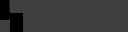

by


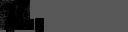

Thiss


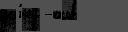

goingaut


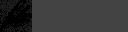

flan


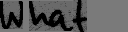

What


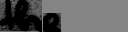

the


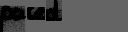

pared


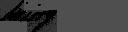

ting


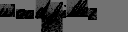

wrodfilen


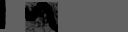

in


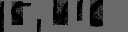

15.46


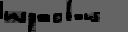

Inspectors


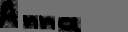

Ana


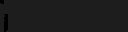

;


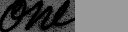

Oml


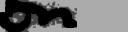

on


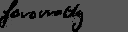

fovowrody


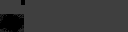

in


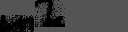

wite


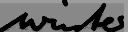

wites


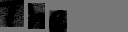

The


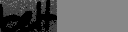

bet


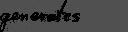

generates


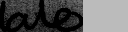

laler


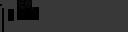

jokes


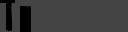

TV


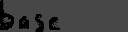

base


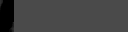

,


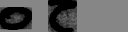

ol


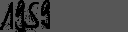

1is8


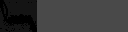

lang


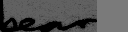

bear


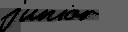

junian


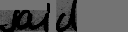

said


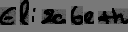

Elizabeth


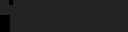

;


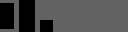

Hific


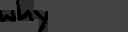

why


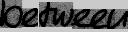

betuen


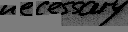

necesary


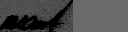

meant


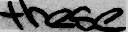

these


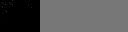

he


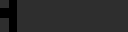

of


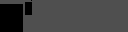

get


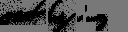

onutlying


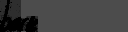

back


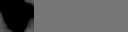

.


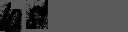

last


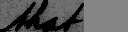

that


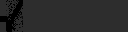

of


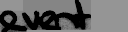

event


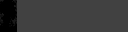

2


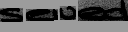

seived


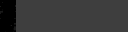

,


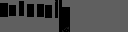

nathraly


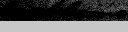

Foptare


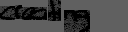

Ereciting


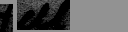

tel


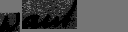

want


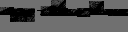

apersturctre


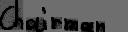

Chairman


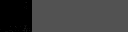

few


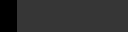

)


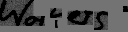

Workers


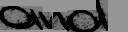

ad


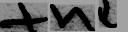

thl


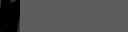

"


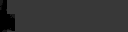

In


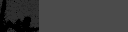

he


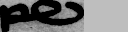

per


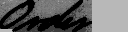

Order


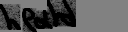

heald


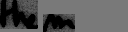

them


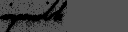

mporilile


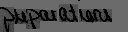

phipariatisns


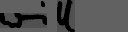

wil


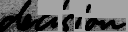

decision


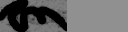

an


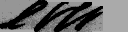

eve


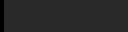

,


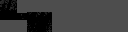

Haney


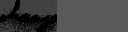

change


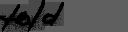

feld


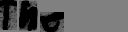

The


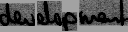

develsprent


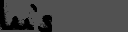

his


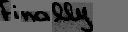

finaly


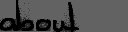

aboul


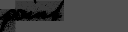

paint


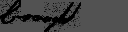

brauft


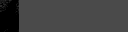

to


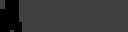

the


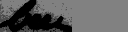

ben


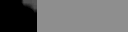

.


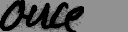

ouce


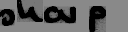

sharp


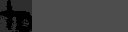

to


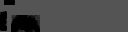

in


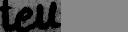

tel


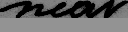

mea


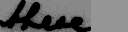

there


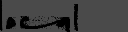

lacal


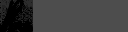

the


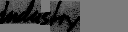

industry


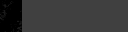

,


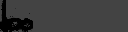

to


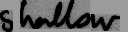

shalowr


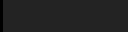

I


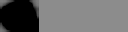

.


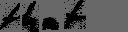

that


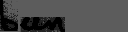

ben


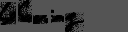

belaving


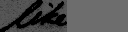

like


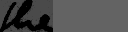

the


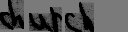

church


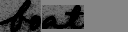

boat


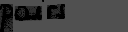

pairs


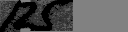

125


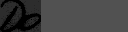

To


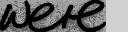

were


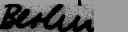

Berliin


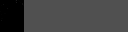

3


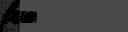

fe


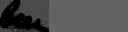

ben


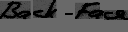

Backace


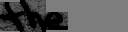

the


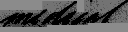

medint


In [24]:
show_prediction(pred_model, test_generator[0][0])